## EPL Data from link
https://github.com/tara-nguyen/english-premier-league-datasets-for-10-seasons

Description: EPL data of 10 seasons, with half time & full time score information for each game w/ dates.

Aim: To explore the dataset & train a model to be able to predict the outcome of a new game played b/w the teams.



In [1]:
# libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import bqplot as bq
#pip install side-by-side
from side_by_side import print_side_by_side

from pandas.api.types import CategoricalDtype
from sklearn import multioutput
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, classification_report

from sklearn.utils import compute_class_weight
import json as js


In [2]:
%matplotlib inline

In [3]:
plt.style.use('classic')
pd.options.display.float_format = '{:.1f}'.format

df = pd.read_csv('epl-allseasons-matchstats.csv')
display(df.head(2), df.tail(2))

,Season,Date,Referee,HomeTeam,AwayTeam,FullTime,Halftime,HomeGoals,HomeGoalsHalftime,HomeShots,...,HomeYellowCards,HomeRedCards,AwayGoals,AwayGoalsHalftime,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
0,2010/11,2010-08-14,M Dean,Aston Villa,West Ham,HomeWin,HomeWin,3,2,23,...,1,0,0,0,12,2,7,15,2,0
1,2010/11,2010-08-14,P Dowd,Blackburn,Everton,HomeWin,HomeWin,1,1,7,...,2,0,0,0,17,12,3,14,1,0


,Season,Date,Referee,HomeTeam,AwayTeam,FullTime,Halftime,HomeGoals,HomeGoalsHalftime,HomeShots,...,HomeYellowCards,HomeRedCards,AwayGoals,AwayGoalsHalftime,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
3798,2019/20,2020-07-26,P Bankes,Southampton,Sheffield United,HomeWin,AwayWin,3,0,13,...,0,0,1,1,5,3,1,16,1,0
3799,2019/20,2020-07-26,M Oliver,West Ham,Aston Villa,Draw,Draw,1,0,10,...,2,0,1,0,13,4,7,13,1,0


In [4]:
display(df.dtypes)
display(df.shape)

Season               object
Date                 object
Referee              object
HomeTeam             object
AwayTeam             object
FullTime             object
Halftime             object
HomeGoals             int64
HomeGoalsHalftime     int64
HomeShots             int64
HomeShotsOnTarget     int64
HomeCorners           int64
HomeFouls             int64
HomeYellowCards       int64
HomeRedCards          int64
AwayGoals             int64
AwayGoalsHalftime     int64
AwayShots             int64
AwayShotsOnTarget     int64
AwayCorners           int64
AwayFouls             int64
AwayYellowCards       int64
AwayRedCards          int64
dtype: object

(3800, 23)

In [5]:
display(np.sum(df.isnull()))

Season               0
Date                 0
Referee              0
HomeTeam             0
AwayTeam             0
FullTime             0
Halftime             0
HomeGoals            0
HomeGoalsHalftime    0
HomeShots            0
HomeShotsOnTarget    0
HomeCorners          0
HomeFouls            0
HomeYellowCards      0
HomeRedCards         0
AwayGoals            0
AwayGoalsHalftime    0
AwayShots            0
AwayShotsOnTarget    0
AwayCorners          0
AwayFouls            0
AwayYellowCards      0
AwayRedCards         0
dtype: int64

In [6]:
df.Season = pd.Categorical(df.Season)
df.HomeTeam = pd.Categorical(df.HomeTeam)
df.Referee = pd.Categorical(df.Referee)
df.AwayTeam = pd.Categorical(df.AwayTeam)
df.FullTime = pd.Categorical(df.FullTime)
df.Halftime = pd.Categorical(df.Halftime)

In [7]:
cat = CategoricalDtype(categories=df.Season.unique(), ordered = True)
df.Season = df.Season.astype(cat);df.Season.unique() # since we are going to make predictions at some point, it serves better to have an ordered category of seasons based on relevance.

['2010/11', '2011/12', '2012/13', '2013/14', '2014/15', '2015/16', '2016/17', '2017/18', '2018/19', '2019/20']
Categories (10, object): ['2010/11' < '2011/12' < '2012/13' < '2013/14' ... '2016/17' < '2017/18' < '2018/19' < '2019/20']

In [8]:
categorical = df.iloc[:,[0,2,3,4,5,6]]
display(categorical.head(2))

,Season,Referee,HomeTeam,AwayTeam,FullTime,Halftime
0,2010/11,M Dean,Aston Villa,West Ham,HomeWin,HomeWin
1,2010/11,P Dowd,Blackburn,Everton,HomeWin,HomeWin


In [9]:
display('Number of categories for categorical columns',
        {df.columns[i]: df.iloc[:,i].cat.categories.nunique() for i in np.array([0,2,3,4,5,6])})

'Number of categories for categorical columns'

{'Season': 10,
 'Referee': 35,
 'HomeTeam': 36,
 'AwayTeam': 36,
 'FullTime': 3,
 'Halftime': 3}

In [10]:
df.Date = pd.to_datetime(df.Date, infer_datetime_format=True)

In [11]:
display(df.Date.dtype, df.Date.head(2)) 

dtype('<M8[ns]')

0   2010-08-14
1   2010-08-14
Name: Date, dtype: datetime64[ns]

In [12]:
df.dtypes

Season                     category
Date                 datetime64[ns]
Referee                    category
HomeTeam                   category
AwayTeam                   category
FullTime                   category
Halftime                   category
HomeGoals                     int64
HomeGoalsHalftime             int64
HomeShots                     int64
HomeShotsOnTarget             int64
HomeCorners                   int64
HomeFouls                     int64
HomeYellowCards               int64
HomeRedCards                  int64
AwayGoals                     int64
AwayGoalsHalftime             int64
AwayShots                     int64
AwayShotsOnTarget             int64
AwayCorners                   int64
AwayFouls                     int64
AwayYellowCards               int64
AwayRedCards                  int64
dtype: object

#### visualize club goals over seasons.

In [13]:
hometeam = df.groupby('HomeTeam')['HomeGoals'].sum().sort_values(ascending =False)
hometeam.head(7)

HomeTeam
Man City      496
Liverpool     407
Arsenal       398
Chelsea       386
Man United    380
Tottenham     351
Everton       316
Name: HomeGoals, dtype: int64

In [14]:
awayteam = df.groupby('AwayTeam')['AwayGoals'].sum().sort_values(ascending=False);
awayteam.head(7)

AwayTeam
Man City      362
Liverpool     322
Tottenham     306
Chelsea       305
Arsenal       304
Man United    301
Everton       212
Name: AwayGoals, dtype: int64

In [15]:
viz_df1 = pd.merge(hometeam, awayteam, left_index= True, right_index=True)
viz_df1 = viz_df1.head(20); viz_df1.head()

,HomeGoals,AwayGoals
Man City,496,362
Liverpool,407,322
Arsenal,398,304
Chelsea,386,305
Man United,380,301


[]

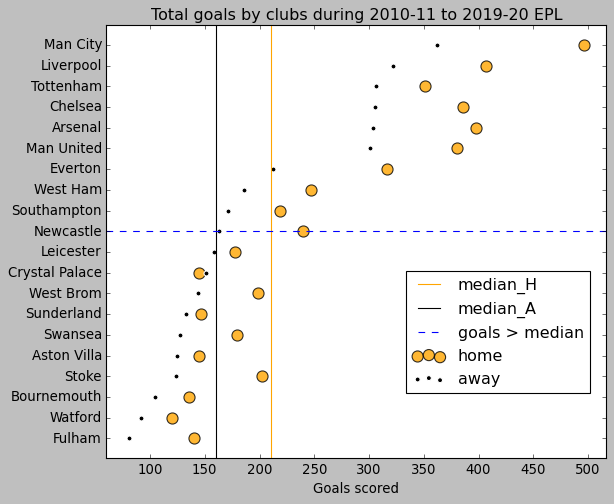

In [16]:
viz_df1.sort_values(by= 'AwayGoals',inplace=True)

plt.scatter(y = viz_df1.index, x = viz_df1.HomeGoals, c= 'orange', edgecolors='black', label= 'home', s=100, \
           alpha = 0.8)
plt.scatter(y = viz_df1.index, x = viz_df1.AwayGoals, c= 'black', edgecolors='white', label= 'away')
#plt.barh(viz_df1.index, viz_df1.AwayGoals, color= 'black', alpha = 0.1, linewidth=0)
plt.tight_layout()
plt.xlabel('Goals scored')
plt.xticks(ticks=np.arange(50,550,step=50))
median= np.median(viz_df1.iloc[:,:], axis=0) # computes median val traversing all rows 
plt.axvline(x = median[0], label= 'median_H', c='orange')
plt.axvline(x = median[1], label= 'median_A', c='black')
#plt.fill_betweenx(y = viz_df1.index,x1 = viz_df1.HomeGoals, x2= viz_df1.AwayGoals, where = (median < viz_df1.AwayGoals), alpha = 0.1)
plt.title('Total goals by clubs during 2010-11 to 2019-20 EPL')

cond1 = viz_df1.index == (viz_df1.index[median[1] < viz_df1.AwayGoals][0]) #[0] picks min value from sorted array
cond2 = viz_df1.index == (viz_df1.index[median[0] < viz_df1.HomeGoals][0]) 

y1 = int(np.argwhere((cond1) & (cond2)))
plt.axhline(y = y1, linestyle='dashed', label = 'goals > median')

#plt.fill_between(np.transpose(viz_df1.AwayGoals[viz_df1.AwayGoals > median].values), np.arange(y1,0,-1))
plt.legend(loc=(0.6,0.15))
plt.plot()

In [17]:
# select clubs which sco
home = df.pivot_table(values= ['HomeGoals','HomeGoalsHalftime'], columns= 'Season', index = 'HomeTeam', sort=True, aggfunc='median')
print(home.shape, home.head(3)) # NaNs indicate these clubs did not play that season. 

(36, 20)             HomeGoals                                                          \
Season        2010/11 2011/12 2012/13 2013/14 2014/15 2015/16 2016/17 2017/18   
HomeTeam                                                                        
Arsenal           2.0     1.0     2.0     2.0     2.0     2.0     2.0     3.0   
Aston Villa       1.0     1.0     1.0     1.0     1.0     1.0     NaN     NaN   
Birmingham        1.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                            HomeGoalsHalftime                                  \
Season      2018/19 2019/20           2010/11 2011/12 2012/13 2013/14 2014/15   
HomeTeam                                                                        
Arsenal         2.0     2.0               0.0     1.0     1.0     1.0     1.0   
Aston Villa     NaN     1.0               1.0     0.0     0.0     0.0     1.0   
Birmingham      NaN     NaN               0.0     NaN     NaN     NaN     NaN   

                 

In [18]:
home.dropna(inplace =True, how='any') # default 'any' drops if a club did not play even a single season 

In [19]:
display(home.index.nunique(), 'teams that were not relegated in the last 10 seasons')
home.index.values

7

'teams that were not relegated in the last 10 seasons'

['Arsenal', 'Chelsea', 'Everton', 'Liverpool', 'Man City', 'Man United', 'Tottenham']
Categories (36, object): ['Arsenal', 'Aston Villa', 'Birmingham', 'Blackburn', ..., 'West Brom', 'West Ham', 'Wigan', 'Wolves']

In [20]:
print(home.columns)
print(type(home))

MultiIndex([(        'HomeGoals', '2010/11'),
            (        'HomeGoals', '2011/12'),
            (        'HomeGoals', '2012/13'),
            (        'HomeGoals', '2013/14'),
            (        'HomeGoals', '2014/15'),
            (        'HomeGoals', '2015/16'),
            (        'HomeGoals', '2016/17'),
            (        'HomeGoals', '2017/18'),
            (        'HomeGoals', '2018/19'),
            (        'HomeGoals', '2019/20'),
            ('HomeGoalsHalftime', '2010/11'),
            ('HomeGoalsHalftime', '2011/12'),
            ('HomeGoalsHalftime', '2012/13'),
            ('HomeGoalsHalftime', '2013/14'),
            ('HomeGoalsHalftime', '2014/15'),
            ('HomeGoalsHalftime', '2015/16'),
            ('HomeGoalsHalftime', '2016/17'),
            ('HomeGoalsHalftime', '2017/18'),
            ('HomeGoalsHalftime', '2018/19'),
            ('HomeGoalsHalftime', '2019/20')],
           names=[None, 'Season'])
<class 'pandas.core.frame.DataFrame'>


In [21]:
home['HomeGoals']['2019/20']
home.reset_index

<bound method DataFrame.reset_index of            HomeGoals                                                          \
Season       2010/11 2011/12 2012/13 2013/14 2014/15 2015/16 2016/17 2017/18   
HomeTeam                                                                       
Arsenal          2.0     1.0     2.0     2.0     2.0     2.0     2.0     3.0   
Chelsea          2.0     2.0     2.0     2.0     2.0     2.0     3.0     1.0   
Everton          2.0     1.0     2.0     2.0     1.0     2.0     2.0     1.0   
Liverpool        2.0     1.0     1.0     3.0     2.0     1.0     2.0     2.0   
Man City         1.0     3.0     2.0     3.0     2.0     2.0     2.0     3.0   
Man United       2.0     2.0     2.0     1.0     2.0     1.0     1.0     2.0   
Tottenham        2.0     2.0     2.0     1.0     2.0     2.0     2.0     1.0   

                           HomeGoalsHalftime                                  \
Season     2018/19 2019/20           2010/11 2011/12 2012/13 2013/14 2014/15   


- multilabel classification? regression. if classification make goals as categories.
- make boxplot for 2nd viz, x = teams , y = Goals.


In [22]:
display(df.dtypes)
display(df.shape)
display(df.head(1))

Season                     category
Date                 datetime64[ns]
Referee                    category
HomeTeam                   category
AwayTeam                   category
FullTime                   category
Halftime                   category
HomeGoals                     int64
HomeGoalsHalftime             int64
HomeShots                     int64
HomeShotsOnTarget             int64
HomeCorners                   int64
HomeFouls                     int64
HomeYellowCards               int64
HomeRedCards                  int64
AwayGoals                     int64
AwayGoalsHalftime             int64
AwayShots                     int64
AwayShotsOnTarget             int64
AwayCorners                   int64
AwayFouls                     int64
AwayYellowCards               int64
AwayRedCards                  int64
dtype: object

(3800, 23)

,Season,Date,Referee,HomeTeam,AwayTeam,FullTime,Halftime,HomeGoals,HomeGoalsHalftime,HomeShots,...,HomeYellowCards,HomeRedCards,AwayGoals,AwayGoalsHalftime,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
0,2010/11,2010-08-14,M Dean,Aston Villa,West Ham,HomeWin,HomeWin,3,2,23,...,1,0,0,0,12,2,7,15,2,0


In [23]:
#X = df.drop(columns= ['Season', 'Date', 'Referee','FullTime','Halftime','HomeGoals','HomeGoalsHalftime','AwayGoals', 'AwayGoalsHalftime'])
X = df.drop(columns= ['Season', 'Date', 'Referee','HomeGoals','HomeGoalsHalftime','AwayGoals', 'AwayGoalsHalftime'])

In [24]:
X.columns

Index(['HomeTeam', 'AwayTeam', 'FullTime', 'Halftime', 'HomeShots',
       'HomeShotsOnTarget', 'HomeCorners', 'HomeFouls', 'HomeYellowCards',
       'HomeRedCards', 'AwayShots', 'AwayShotsOnTarget', 'AwayCorners',
       'AwayFouls', 'AwayYellowCards', 'AwayRedCards'],
      dtype='object')

In [25]:
y = df.loc[:][['HomeGoals','AwayGoals']]

In [26]:
display(X.head(),y.head())

,HomeTeam,AwayTeam,FullTime,Halftime,HomeShots,HomeShotsOnTarget,HomeCorners,HomeFouls,HomeYellowCards,HomeRedCards,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
0,Aston Villa,West Ham,HomeWin,HomeWin,23,11,16,15,1,0,12,2,7,15,2,0
1,Blackburn,Everton,HomeWin,HomeWin,7,2,1,19,2,0,17,12,3,14,1,0
2,Bolton,Fulham,Draw,Draw,13,9,4,12,1,0,12,7,8,13,3,0
3,Chelsea,West Brom,HomeWin,HomeWin,18,13,3,10,1,0,10,4,1,10,0,0
4,Sunderland,Birmingham,Draw,HomeWin,6,2,3,13,3,1,13,7,6,10,3,0


,HomeGoals,AwayGoals
0,3,0
1,1,0
2,0,0
3,6,0
4,2,2


In [27]:
X.dtypes

HomeTeam             category
AwayTeam             category
FullTime             category
Halftime             category
HomeShots               int64
HomeShotsOnTarget       int64
HomeCorners             int64
HomeFouls               int64
HomeYellowCards         int64
HomeRedCards            int64
AwayShots               int64
AwayShotsOnTarget       int64
AwayCorners             int64
AwayFouls               int64
AwayYellowCards         int64
AwayRedCards            int64
dtype: object

In [28]:
a = pd.get_dummies(X.HomeTeam, prefix='H')
b = pd.get_dummies(X.AwayTeam, prefix='A')
c = pd.get_dummies(X[['FullTime','Halftime']])


X = X.merge(a, left_index=True, right_index=True)
X = X.merge(b, left_index=True, right_index=True)
X = X.merge(c, left_index=True, right_index=True)
X.columns = X.columns.str.replace("_x","")
X.columns = X.columns.str.replace("_y","")
X.head()

,HomeTeam,AwayTeam,FullTime,Halftime,HomeShots,HomeShotsOnTarget,HomeCorners,HomeFouls,HomeYellowCards,HomeRedCards,...,A_West Brom,A_West Ham,A_Wigan,A_Wolves,FullTime_AwayWin,FullTime_Draw,FullTime_HomeWin,Halftime_AwayWin,Halftime_Draw,Halftime_HomeWin
0,Aston Villa,West Ham,HomeWin,HomeWin,23,11,16,15,1,0,...,0,1,0,0,0,0,1,0,0,1
1,Blackburn,Everton,HomeWin,HomeWin,7,2,1,19,2,0,...,0,0,0,0,0,0,1,0,0,1
2,Bolton,Fulham,Draw,Draw,13,9,4,12,1,0,...,0,0,0,0,0,1,0,0,1,0
3,Chelsea,West Brom,HomeWin,HomeWin,18,13,3,10,1,0,...,1,0,0,0,0,0,1,0,0,1
4,Sunderland,Birmingham,Draw,HomeWin,6,2,3,13,3,1,...,0,0,0,0,0,1,0,0,0,1


In [29]:
X.shape

(3800, 94)

In [30]:
X.drop(X.columns[:4],axis=1, inplace=True)

In [31]:
X.head() # x is ready to be fit

,HomeShots,HomeShotsOnTarget,HomeCorners,HomeFouls,HomeYellowCards,HomeRedCards,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,...,A_West Brom,A_West Ham,A_Wigan,A_Wolves,FullTime_AwayWin,FullTime_Draw,FullTime_HomeWin,Halftime_AwayWin,Halftime_Draw,Halftime_HomeWin
0,23,11,16,15,1,0,12,2,7,15,...,0,1,0,0,0,0,1,0,0,1
1,7,2,1,19,2,0,17,12,3,14,...,0,0,0,0,0,0,1,0,0,1
2,13,9,4,12,1,0,12,7,8,13,...,0,0,0,0,0,1,0,0,1,0
3,18,13,3,10,1,0,10,4,1,10,...,1,0,0,0,0,0,1,0,0,1
4,6,2,3,13,3,1,13,7,6,10,...,0,0,0,0,0,1,0,0,0,1


In [32]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y)

In [33]:
display({'xtrain': xtrain.shape,'xtest': xtest.shape},{'ytrain':ytrain.shape,'ytest':ytest.shape})

{'xtrain': (2850, 90), 'xtest': (950, 90)}

{'ytrain': (2850, 2), 'ytest': (950, 2)}

In [34]:
model = LinearRegression(normalize=True)
m = model.fit(xtrain,ytrain)
yhat = m.predict(xtest)

In [35]:
mse = mean_squared_error(yhat, ytest)
r2 = r2_score(yhat, ytest)

In [36]:
display({'mse': f'{mse:3.2f}'}, {'r2': f'{r2:3.2f}'},\
        {'sd_homegoals': f'{np.std(df.HomeGoals,axis=0):3.2f}'},{'sd_awaygoals': f'{np.std(df.AwayGoals,axis=0):3.2f}'})
print('\ntrying out a classification here since decimal goals don''t mean anything')

{'mse': '0.64'}

{'r2': '0.28'}

{'sd_homegoals': '1.30'}

{'sd_awaygoals': '1.17'}


trying out a classification here since decimal goals dont mean anything


In [37]:
ybar= m.predict(xtest[1:5])
display({'y_actual': ytest[1:5], 'y_pred': pd.DataFrame({'HomeGoals':ybar[:,0],'AwayGoals':ybar[:,1]})})

{'y_actual':       HomeGoals  AwayGoals
 613           1          2
 2922          1          1
 2398          0          1
 183           0          2,
 'y_pred':    HomeGoals  AwayGoals
 0        1.1        2.2
 1        0.7        1.5
 2        0.4        2.1
 3        1.9        2.2}

#### Setting a multilabel classification. 
-    Changing HomeGoals, AwayGoals to categorical. Adding Fulltime, Halftime categorical data also to the y output. 
-    n_target_variable > 1

In [38]:
y.dtypes
#cat = CategoricalDtype(categories= y.HomeGoals.unique().astype('str'))
y.HomeGoals = pd.Categorical(y.HomeGoals.astype(str))
y.HomeGoals.unique()

['3', '1', '0', '6', '2', '4', '5', '7', '8']
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']

In [39]:
df.iloc[df.HomeGoals.sort_values(ascending=False).index[0:5]]

,Season,Date,Referee,HomeTeam,AwayTeam,FullTime,Halftime,HomeGoals,HomeGoalsHalftime,HomeShots,...,HomeYellowCards,HomeRedCards,AwayGoals,AwayGoalsHalftime,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
405,2011/12,2011-08-28,H Webb,Man United,Arsenal,HomeWin,HomeWin,8,3,25,...,2,0,2,1,19,13,5,7,3,1
1596,2014/15,2014-10-18,A Marriner,Southampton,Sunderland,HomeWin,HomeWin,8,3,20,...,1,0,0,0,12,1,6,8,3,0
3474,2019/20,2019-09-21,M Dean,Man City,Watford,HomeWin,HomeWin,8,5,28,...,2,0,0,0,5,4,4,9,2,0
937,2012/13,2012-12-23,P Dowd,Chelsea,Aston Villa,HomeWin,HomeWin,8,3,24,...,0,0,0,0,7,4,4,11,0,0
2733,2017/18,2017-10-14,C Pawson,Man City,Stoke,HomeWin,HomeWin,7,3,20,...,0,0,2,1,5,1,0,8,1,0


In [40]:
#cat = CategoricalDtype(categories= y.AwayGoals.unique().astype('str'))
y.AwayGoals = pd.Categorical(y.AwayGoals.astype(str))
y.AwayGoals.unique() # category for 8 missing. 

['0', '2', '4', '1', '3', '6', '5', '7', '9']
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '9']

In [41]:
df.iloc[df.AwayGoals.sort_values(ascending=False).index[0:5]]

,Season,Date,Referee,HomeTeam,AwayTeam,FullTime,Halftime,HomeGoals,HomeGoalsHalftime,HomeShots,...,HomeYellowCards,HomeRedCards,AwayGoals,AwayGoalsHalftime,AwayShots,AwayShotsOnTarget,AwayCorners,AwayFouls,AwayYellowCards,AwayRedCards
3510,2019/20,2019-10-25,A Marriner,Southampton,Leicester,AwayWin,AwayWin,0,0,6,...,0,1,9,5,25,15,7,12,0,0
2653,2016/17,2017-05-21,A Marriner,Hull,Tottenham,AwayWin,AwayWin,1,0,10,...,0,0,7,3,19,14,3,5,0,0
1099,2012/13,2013-04-27,A Marriner,Newcastle,Liverpool,AwayWin,AwayWin,0,0,5,...,3,1,6,2,11,10,7,7,2,0
16,2010/11,2010-08-21,M Dean,Wigan,Chelsea,AwayWin,AwayWin,0,0,17,...,1,0,6,1,10,8,0,7,2,0
467,2011/12,2011-10-23,M Clattenburg,Man United,Man City,AwayWin,AwayWin,1,0,12,...,4,1,6,1,19,12,4,11,4,0


In [42]:
y = y.merge(df.loc[:,['FullTime','Halftime']],left_index=True,right_index=True)
y.dtypes 
# in retrospect Halftime & FullTime may enhance model for predictinng goals being independent variables, as scoreline would be easier to predict
# knowing the outcome win/loss at two intervals. 

HomeGoals    category
AwayGoals    category
FullTime     category
Halftime     category
dtype: object

In [43]:
y.head()

,HomeGoals,AwayGoals,FullTime,Halftime
0,3,0,HomeWin,HomeWin
1,1,0,HomeWin,HomeWin
2,0,0,Draw,Draw
3,6,0,HomeWin,HomeWin
4,2,2,Draw,HomeWin


In [44]:
y = pd.get_dummies(data = y, drop_first=False, columns= ['FullTime','Halftime'])
y.head()

,HomeGoals,AwayGoals,FullTime_AwayWin,FullTime_Draw,FullTime_HomeWin,Halftime_AwayWin,Halftime_Draw,Halftime_HomeWin
0,3,0,0,0,1,0,0,1
1,1,0,0,0,1,0,0,1
2,0,0,0,1,0,0,1,0
3,6,0,0,0,1,0,0,1
4,2,2,0,1,0,0,0,1


In [45]:
y.dtypes

HomeGoals           category
AwayGoals           category
FullTime_AwayWin       uint8
FullTime_Draw          uint8
FullTime_HomeWin       uint8
Halftime_AwayWin       uint8
Halftime_Draw          uint8
Halftime_HomeWin       uint8
dtype: object

In [46]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y)

In [47]:
tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
tmodel = tree.fit(xtrain, ytrain.iloc[:,0:2])

In [48]:
yhat = tmodel.predict(xtest)

{'acc for home goals': 0.44526315789473686}

array([[151,  77,   9,   0,   0,   0,   0],
       [ 91, 126,  57,  17,   3,   2,   0],
       [ 16,  57, 105,  38,   4,   3,   0],
       [  3,  16,  55,  36,   5,   5,   0],
       [  0,   5,  23,  13,   4,   3,   0],
       [  0,   1,   6,   6,   5,   1,   0],
       [  0,   0,   2,   1,   2,   2,   0]])

<AxesSubplot:>

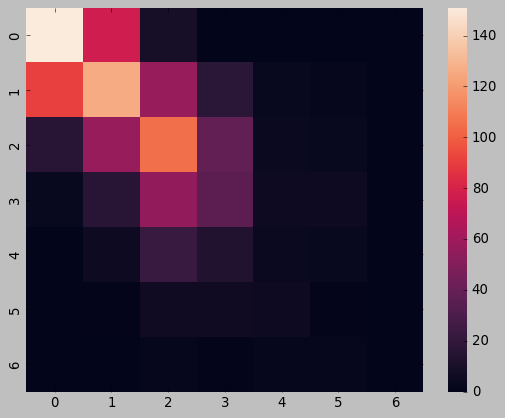

In [49]:
c = confusion_matrix(ytest.iloc[:,0],yhat[:,0]) # error : multiclass-multio/p not supported
display({'acc for home goals': accuracy_score(ytest.iloc[:,0],yhat[:,0])}, c)
sns.heatmap(c)


{'acc for home goals': 0.5042105263157894}

<AxesSubplot:>

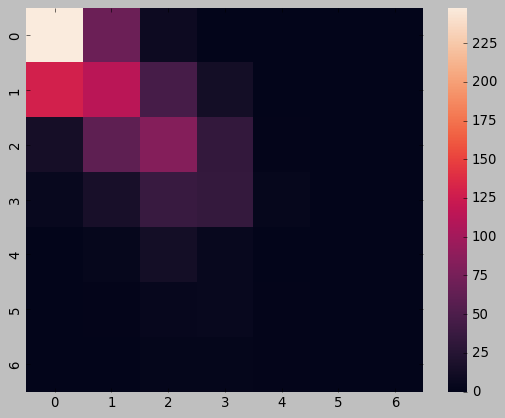

In [50]:
c1 = confusion_matrix(ytest.iloc[:,1],yhat[:,1]) # away goals
display({'acc for home goals':accuracy_score(ytest.iloc[:,1],yhat[:,1])})
sns.heatmap(c1)


In [51]:
print('Home Goals prediction:\n\n',classification_report(ytest.iloc[:,0],yhat[:,0], zero_division= 0),\
     '\nAway Goals prediction:\n\n',classification_report(ytest.iloc[:,1],yhat[:,1], zero_division= 0))

Home Goals prediction:

               precision    recall  f1-score   support

           0       0.58      0.64      0.61       237
           1       0.45      0.43      0.44       296
           2       0.41      0.47      0.44       223
           3       0.32      0.30      0.31       120
           4       0.17      0.08      0.11        48
           5       0.06      0.05      0.06        19
           6       0.00      0.00      0.00         7

    accuracy                           0.45       950
   macro avg       0.28      0.28      0.28       950
weighted avg       0.43      0.45      0.44       950
 
Away Goals prediction:

               precision    recall  f1-score   support

           0       0.63      0.77      0.69       324
           1       0.43      0.38      0.40       302
           2       0.43      0.43      0.43       192
           3       0.37      0.36      0.36        95
           4       0.00      0.00      0.00        21
           5       0.00    

### apply class weights based on homegoals distribution. 

In [52]:
class_weights_h = compute_class_weight('balanced',classes= y.HomeGoals.unique(), y = y.iloc[:,0] )
#class_weights_a = compute_class_weight('balanced',classes= y.AwayGoals.unique(), y = y.iloc[:,1] )

In [53]:
tree1 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, class_weight=class_weights_h)
tmodel1 = tree.fit(xtrain, ytrain.iloc[:,0:2])
yhat1 = tmodel1.predict(xtest)

In [54]:
print('Home Goals prediction:\n\n',classification_report(ytest.iloc[:,0],yhat1[:,0], zero_division= 0),\
     '\nAway Goals prediction:\n\n',classification_report(ytest.iloc[:,1],yhat1[:,1], zero_division= 0))


Home Goals prediction:

               precision    recall  f1-score   support

           0       0.58      0.64      0.61       237
           1       0.45      0.43      0.44       296
           2       0.41      0.47      0.44       223
           3       0.32      0.30      0.31       120
           4       0.17      0.08      0.11        48
           5       0.06      0.05      0.06        19
           6       0.00      0.00      0.00         7

    accuracy                           0.45       950
   macro avg       0.28      0.28      0.28       950
weighted avg       0.43      0.45      0.44       950
 
Away Goals prediction:

               precision    recall  f1-score   support

           0       0.63      0.77      0.69       324
           1       0.43      0.38      0.40       302
           2       0.43      0.43      0.43       192
           3       0.37      0.36      0.36        95
           4       0.00      0.00      0.00        21
           5       0.00    